Kimberly Adams

Summer 2023

Applying clustering methods to anonymized data on ALS patients.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import data from csv into dataframe and then display dataframe
data1 = pd.read_csv (r'/Users/kimberlyadams/Documents/GitHub/Portfolio/Models/Clustering/als_data.csv')
alsdata = pd.DataFrame(data1)
alsdata

,ID,Age_mean,Albumin_max,Albumin_median,Albumin_min,Albumin_range,ALSFRS_slope,ALSFRS_Total_max,ALSFRS_Total_median,ALSFRS_Total_min,...,Sodium_min,Sodium_range,SubjectID,trunk_max,trunk_median,trunk_min,trunk_range,Urine.Ph_max,Urine.Ph_median,Urine.Ph_min
0,1,65,57.0,40.5,38.0,0.066202,-0.965608,30,28.0,22,...,143.0,0.017422,533,8,7.0,7,0.002646,6.00,6.0,6.0
1,2,48,45.0,41.0,39.0,0.010453,-0.921717,37,33.0,21,...,136.0,0.010453,649,8,7.0,5,0.005386,7.00,5.0,5.0
2,3,38,50.0,47.0,45.0,0.008929,-0.914787,24,14.0,10,...,140.0,0.008929,1234,5,0.0,0,0.008929,6.00,5.0,5.0
3,4,63,47.0,44.0,41.0,0.012111,-0.598361,30,29.0,24,...,138.0,0.012469,2492,5,5.0,3,0.004988,7.00,6.0,5.0
4,5,63,47.0,45.5,42.0,0.008292,-0.444039,32,27.5,20,...,138.0,0.008292,2956,6,4.0,1,0.008489,6.00,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2218,2419,33,50.0,49.0,45.0,0.008772,-0.239501,35,32.5,30,...,136.0,0.014035,997136,7,5.0,5,0.003643,7.00,6.0,5.0
2219,2420,61,47.0,45.0,42.0,0.009074,-0.388711,31,26.0,17,...,141.0,0.009074,998047,5,4.0,3,0.003630,7.41,5.5,5.0
2220,2421,47,46.0,44.0,41.0,0.012111,-0.108631,26,23.0,20,...,135.0,0.013123,998773,5,4.0,4,0.001825,9.00,6.0,5.0
2221,2422,37,49.0,44.0,39.0,0.017857,-0.855880,34,29.5,21,...,136.0,0.007143,998908,8,4.5,2,0.010714,6.00,5.0,5.0


Remove data that is not relevant to the patient’s ALS condition.

In [3]:
# Drop identification columns as they do not add to the analysis
alsdata.drop(['ID','SubjectID','Gender_mean'], axis=1, inplace=True)

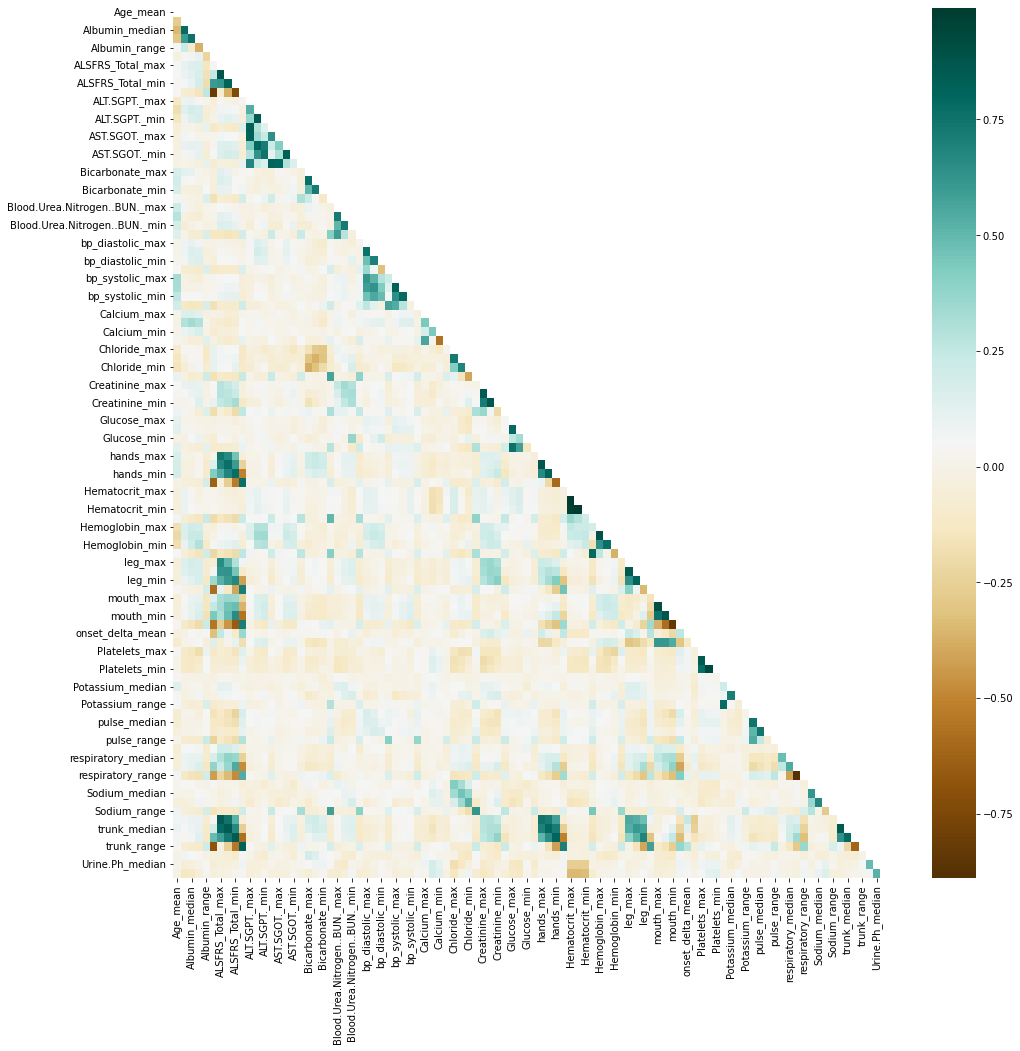

In [4]:
# Create triangular heat map of the correlations between variables to see highly correlated ones.
# Make plot big enough to see
plt.figure(figsize=(16, 16))
matrix = alsdata.corr()

# Define a mask to hide the upper portion of the heat map with the mirrored values
mask = np.triu(np.ones_like(matrix, dtype=np.bool))

# Build and color plot
heatmap = sns.heatmap(matrix, mask=mask, cmap='BrBG')

In [5]:
# Select the data in the upper triangle of correlation matrix above the diagonal correlation = 1 line.
upper = matrix.where(np.triu(np.ones(matrix.shape), k=1).astype(np.bool))

# Select features with correlations greater than 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

# Drop the selected features from the dataframe
alsdata.drop(to_drop, axis=1, inplace=True)
alsdata.shape

(2223, 94)

94 variables left after removing variables from pairs that shared correlations above 0.9.

Apply a standard scalar to the data.

In [6]:
from sklearn.preprocessing import StandardScaler

# Define instance of standard scaler
scaler = StandardScaler()

# Transform the data using the standard scaler and convert the resulting output back into a dataframe
scaled = pd.DataFrame(scaler.fit_transform(alsdata), columns = alsdata.columns)

Create a plot of the cluster silhouette score versus the number of clusters in a K-means cluster.

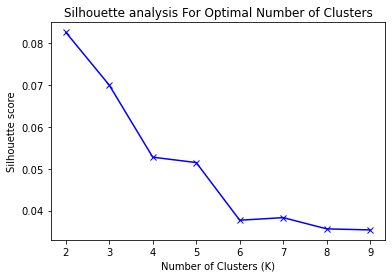

In [7]:
# Import packages
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Define range of cluster numbers to try
range_n_clusters = range(2,10)

# Create empty dataframe for silhouette score averages
silhouette_avg = []

# Caluclate silhouette scores for each cluster value in a K-means clustering model
for num_clusters in range_n_clusters:
    # Initialise and fit K-means cluster model to the scaled data
    kmeans = KMeans(n_clusters=num_clusters, random_state=10)
    kmeans.fit(scaled)
    cluster_labels = kmeans.labels_
 
    # Calcuate silhouette scores and add to empty dataframe
    silhouette_avg.append(silhouette_score(scaled, cluster_labels))

# Plot the number of clusters vs silhouette score
plt.plot(range_n_clusters,silhouette_avg,'bx-')
plt.xlabel('Number of Clusters (K)') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal Number of Clusters')
plt.show()

I am choosing K = 2 to be the optimal number of clusters since that is where the silhouette score maxes out. 

Fit a K-means model to the data with the optimal number of clusters.

In [8]:
# Define optimal number of clusters based on plot
optimalK = 2

# Define and fit a K-means model using the optimal cluster size
kmeansOpt = KMeans(n_clusters=optimalK, random_state=10)
model = kmeansOpt.fit(scaled)

Fit a PCA transformation with two features to the scaled data.

In [9]:
# Import package
from sklearn.decomposition import PCA

# Define instance of PCA with 2 features
pca = PCA(n_components=2)

# Fit PCA transformation to previously scaled data
scaledPCA = pca.fit_transform(scaled)

# Create dataframe from the PCA transformed data with labeled columns
Componets_df = pd.DataFrame(data=scaledPCA, columns=['Component1', 'Component2'])

Make a scatterplot of the PCA transformed data coloring each point by its cluster value.

Text(0, 0.5, 'Component 2')

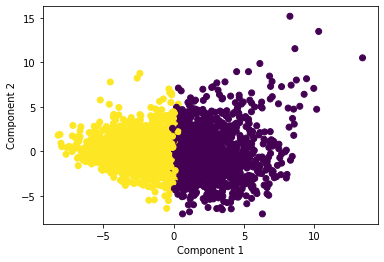

In [10]:
# Create a scatterplot of the 2 components versus each other and color by cluster value
plt.scatter(x=Componets_df.Component1, y=Componets_df.Component2, c=model.labels_.astype(float))
plt.xlabel('Component 1')
plt.ylabel('Component 2')

Despite the silhouette score being so low (just over 0.08), the PCA transformation combined with K-means, each with two features, appears to have helped create two distinct, but adjoining clusters of data points.  This means that it might be possible to draw a line between the two clusters as a boundary. However, there will still be some gray area where confidence on correct cluster assignment would be lower than if the groups were more spread apart without touching each other.

Just for grins and giggles, let's see what is looks like if we try K=3...

Text(0, 0.5, 'Component 2')

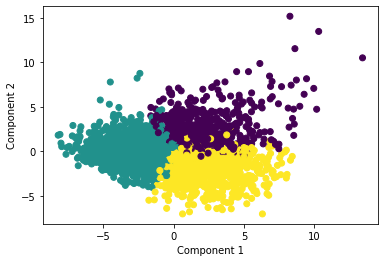

In [11]:
# Define second optimal number of clusters based on silhouette plot
optimalK2 = 3

# Define and fit a K-means model using the second optimal cluster size
kmeansOpt2 = KMeans(n_clusters=optimalK2, random_state=10)
model2 = kmeansOpt2.fit(scaled)

# Create a scatterplot of the 2 components versus each other and color by cluster value
plt.scatter(x=Componets_df.Component1, y=Componets_df.Component2, c=model2.labels_.astype(float))
plt.xlabel('Component 1')
plt.ylabel('Component 2')

Looks like there might be some merit to adding the purple group, though there appears to be considerable overlap with both other colors.  All the clusters remain touching so adding the extra groups adds to the uncertainty in group assignment.  It is safer to stick with 2 clusters for now.

### Resources

Galarnyk, Michael. “PCA Using Python: A Tutorial.” Built In, 29 Nov. 2022, builtin.com/machine-learning/pca-in-python.

“How to Drop out Highly Correlated Features in Python?” ProjectPro, 5 Apr. 2023, www.projectpro.io/recipes/drop-out-highly-correlated-features-in-python. 